<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import pennylane as qml
from matplotlib import pyplot as plt
import numpy as np
from numpy import array
import scipy
from scipy.optimize import minimize
import itertools

#Qiskit
from qiskit import *
from qiskit.circuit import Parameter
import qiskit.quantum_info as qi
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram

import sys
sys.path.append('../')

#### Device choice

In [2]:
# Before running this code, you need to load your account using the API token available
# in your welcome page of the IBM Quantum website (https://quantum-computing.ibm.com/). 
# In the first time, you will need to use the command IBMQ.save_account(your_token) 
# to save your account.

# IBMQ.save_account(your_token)
IBMQ.load_account()

# Fill the information (hub, group and project) about your provider
hub = ''
group = ''
project = ''

provider = IBMQ.get_provider(hub=hub,
                             group=group,
                             project=project)

backend = provider.get_backend('ibm_lagos')
back_str = str(backend)
print("Backend:", backend)

Backend: ibm_lagos


In [3]:
# Get noise model from backend
noise_model = NoiseModel.from_backend(backend)

# Get coupling map from backend
coupling_map = backend.configuration().coupling_map

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

# Define layout for transpilation 
if back_str == "ibm_lagos":
    initial_layout = [2, 1, 3, 5]
else:
    initial_layout = [0, 1, 2, 3]
    
print("Initial Layout:", initial_layout)

Initial Layout: [2, 1, 3, 5]


In [4]:
depth = 1 #Ansatz depth
n_rotations = 3 #Number of rotations parameters in each layer of the ansatz
nr_qubits = 1 #Number of qubits

def device(wire, real_device=False):
    
    if real_device == True:
        dev = qml.device("qiskit.ibmq",
                        wires=nr_qubits,
                        backend=back_str,
                        shots=8192,
                        hub=hub,
                        group=group,
                        project=project
                        )
        dev.set_transpile_args(initial_layout=[wire])

    
    else:
        dev = qml.device("qiskit.aer",
                        wires=nr_qubits,
                        noise_model=noise_model,
                        shots=8192,
                        )   
    
    return dev

In [5]:
# Devices' layout
devc = device(initial_layout[0], real_device=False)
devh = device(initial_layout[-1], real_device=False)

#### System Parameters

In [6]:
Iqml = np.identity(2)
Zqml = np.array([[1,0],[0,-1]])

#Temperature
Tc = 0.4
Th = 0.8

T1 = Tc
T2 = Th

beta_c = 1/Tc # 1/Tc
beta_h = 1/Th # 1/Th

# Parameters
w1 = 0.75
w2 = 1
wc = w1
wh = w2

gch = 0.8
g12 = 0.8

# Strokes durations
tq = 1
tw = 1

# Number of Measurement
N = 8

#Trotter steps
M = 1

H1 = (w1 / 2) * Zqml
H2 = (w2 / 2) * Zqml

Hc = (wc / 2) * Zqml
Hh = (wh / 2) * Zqml

if Tc/Th <= w1/w2 and w1/w2 <= 1:
    print("The system is an engine.")
elif w1/w2 < Tc/Th:
    print("The system is a refrigerator.")
elif w1>w2:
    print("The system is a heat accelerator.")

The system is an engine.


In [7]:
#Entropy
Sen = (w1/Tc-w2/Th)
print("Entropy:", Sen)

Entropy: 0.625


### VQT Implementation

In [8]:
import pickle
from datetime import datetime

#Backend name, system date, experiment count
back_str = str(backend)
date = str(datetime.date(datetime.now()))
number = '1'

def save_results(results,name):
    with open('../final_results/'+str(name),'wb') as f:
        pickle.dump(results, f)        

Training...
Cost at Step 0: -1.0383294778560241
Cost at Step 5: -0.5335258698268152
Cost at Step 10: -1.0721449804534138
Cost at Step 15: -1.0721149146179936
Finished after 20 steps.


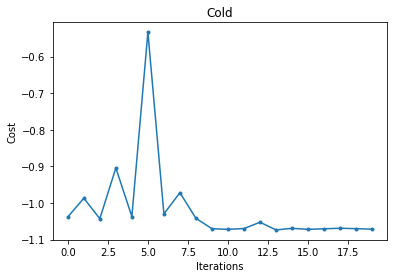

Training...
Cost at Step 0: -0.818073140798872
Cost at Step 5: -0.7266990149611454
Cost at Step 10: -0.8613933362258335
Cost at Step 15: -0.872968658273467
Finished after 20 steps.


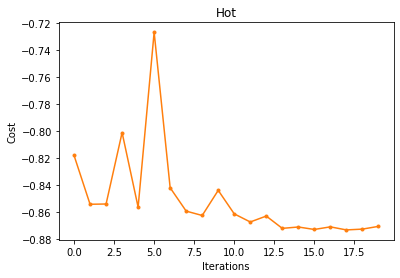

In [9]:
#Implement VQT (True) or use previous ansatz parameters (False)
vqt_on = True

if vqt_on == True:
    %run ../vqt.ipynb
    save_results(out_params_c,f'../params/out_params_c_{back_str}_{date}')
    save_results(out_params_h,f'../params/out_params_h_{back_str}_{date}')
else:
    # open file where previous ansatz parameters are saved
    file_c = open('../params/out_params_c_' + back_str + '_' + date, 'rb')
    file_h = open('../params/out_params_h_' + back_str + '_' + date, 'rb')

    # dump parameters' information to that file
    out_params_c = pickle.load(file_c)
    out_params_h = pickle.load(file_h)

In [10]:
sys_params = {"Tc": Tc, "Th": Th, "w1": w1, "w2": w2, "gch": gch, "g12": g12, "tq": tq, "tw": tw, "N": N}
save_results(sys_params, f'../params/{number}_sys_params_{date}_{back_str}')

### Qiskit Implementation

In [11]:
# Parameters
phis = ['phi'+str(n) for n in range(depth*n_rotations)] #3 rotations
phi = [Parameter(ang) for ang in phis]

Barrier circuit

In [12]:
qc_barrier = QuantumCircuit(4,4)

qc_barrier.barrier()

qc_barrier = qc_barrier.reverse_bits()

VQT Ansatz Circuit

In [13]:
def qc_vqt(wire):
    qc = QuantumCircuit(4,4)
    m=0
    for i in range(depth):
        #RZ-SX-RZ-SX-RZ
        qc.rz(phi[m],wire)
        qc.sx(wire)
        qc.rz(phi[m+1],wire)
        qc.sx(wire)
        qc.rz(phi[m+2],wire)
        m=m+3
    
    qc = qc.reverse_bits()
    return qc

def qc_x(wire):
    qc = QuantumCircuit(4,4)
    qc.x(wire)
    qc = qc.reverse_bits()
    return qc

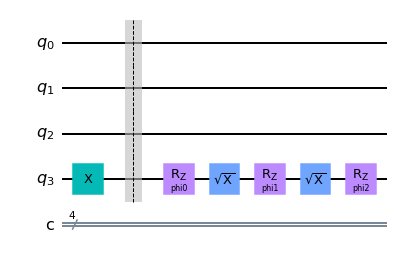

In [14]:
qc_c1 = qc_vqt(0)
qc_c2 = qc_x(0).compose(qc_barrier).compose(qc_c1)
#qc_c2 = qc_x(0).compose(qc_c1)
qc_c2.draw('mpl')

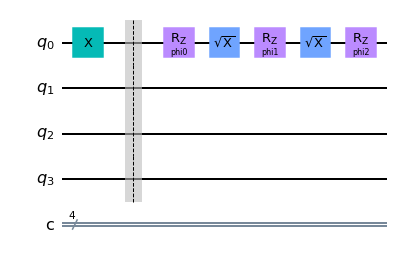

In [15]:
qc_h1 = qc_vqt(3)
qc_h2 = qc_x(3).compose(qc_barrier).compose(qc_h1)
#qc_h2 = qc_x(3).compose(qc_h1)
qc_h2.draw('mpl')

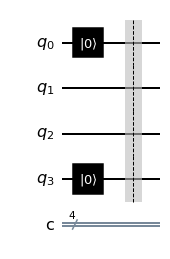

In [16]:
qc_reset = QuantumCircuit(4,4)

qc_reset.reset([0,3])

qc_reset.barrier()

qc_reset = qc_reset.reverse_bits()

qc_reset.draw('mpl')

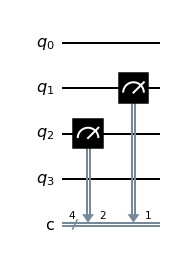

In [17]:
def qc_meas(qubits):
    qc = QuantumCircuit(4,4)

    qc.measure(qubits,qubits)

    qc = qc.reverse_bits()
    
    return qc

qc_meas([1,2]).draw('mpl')

In [18]:
from VQT import prob_dist

# Prepares the optimal parameters and distribution for Hc
dist_params_c = out_params_c[0]
unitary_params_c = out_params_c[1:]
distribution_c = prob_dist(dist_params_c)

# Prepares the optimal parameters and distribution for Hh
dist_params_h = out_params_h[0]
unitary_params_h = out_params_h[1:]
distribution_h = prob_dist(dist_params_h)

# Parameters Bindings
phi_dict_c = dict(zip(phi, unitary_params_c))
phi_dict_h = dict(zip(phi, unitary_params_h))

# Bind Parameters to circuits
qc_c1_bind = qc_c1.bind_parameters(phi_dict_c)
qc_c2_bind = qc_c2.bind_parameters(phi_dict_c)
qc_h1_bind = qc_h1.bind_parameters(phi_dict_h)
qc_h2_bind = qc_h2.bind_parameters(phi_dict_h)

thermal_circs = [qc_c1_bind.compose(qc_h1_bind),
                 qc_h2_bind.compose(qc_c1_bind),
                 qc_c2_bind.compose(qc_h1_bind),
                 qc_c2_bind.compose(qc_h2_bind)]

### Heat Stroke
We are going to use OpFlow from Qiskit

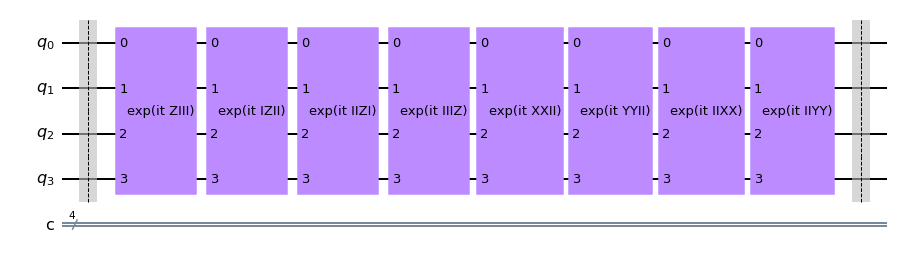

In [19]:
from qiskit.opflow import I, X, Y, Z, PauliTrotterEvolution, Suzuki
#from qiskit.opflow import Zero, ListOp, PauliExpectation, PauliTrotterEvolution, CircuitSampler, MatrixEvolution, Suzuki

Hq = (wc/2) * (Z^I^I^I) + (w1/2) * (I^Z^I^I) + (w2/2) * (I^I^Z^I) + (wh/2) * (I^I^I^Z) + \
     (gch/2) * (X^X^I^I) + (gch/2) * (Y^Y^I^I) + (gch/2) * (I^I^X^X) + (gch/2) * (I^I^Y^Y) 

Uq = (tq*Hq).exp_i()

Uq_trotter = PauliTrotterEvolution(trotter_mode=Suzuki(order=1, reps=1)).convert(Uq)

#qc_heat = qc_barrier.compose(Uq_trotter.to_circuit()).compose(qc_barrier).compose(qc_reset)
qc_heat = qc_barrier.compose(Uq_trotter.to_circuit()).compose(qc_barrier)

qc_heat.decompose().draw('mpl')

In [20]:
def dag(x):
    return x.T.conjugate()

In [21]:
fid_uq = np.trace(Uq_trotter.to_matrix().dot(dag(Uq.to_matrix())))/len(np.array(Uq.to_matrix()))
print("Uq Fidelity: ", fid_uq)

Uq Fidelity:  (1.0000000000000002+0j)


### Work Stroke

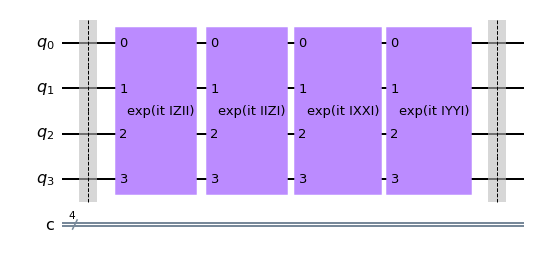

In [22]:
#Work Stroke (Heat Circuit + Work Circuit)
Hw = (w1/2) * (I^Z^I^I) + (w2/2) * (I^I^Z^I) + \
     (g12/2) * (I^X^X^I) + (g12/2) * (I^Y^Y^I) 

Uw = (tw*Hw).exp_i()

Uw_trotter = PauliTrotterEvolution(trotter_mode=Suzuki(order=1, reps=1)).convert(Uw)

qc_work = qc_barrier.compose(Uw_trotter.to_circuit()).compose(qc_barrier).decompose()

qc_work.draw('mpl')

In [23]:
fid_uw = np.trace(Uw_trotter.to_matrix().dot(dag(Uw.to_matrix())))/len(np.array(Uw.to_matrix()))
print("Uw Fidelity: ", fid_uw)

Uw Fidelity:  (0.9978411067736848+0j)


State initialization:

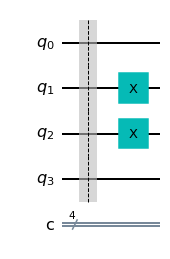

In [24]:
#Initialization circuit

qc_init = QuantumCircuit(4,4)

qc_init.barrier()

qc_init.x(1)
qc_init.x(2)

qc_init = qc_init.reverse_bits()

qc_init.draw('mpl')

Circuits for each stroke:

In [25]:
qc_heat_strokes = []
qc_work_strokes = []

for j in range(len(thermal_circs)):
    qc_heat_stroke = thermal_circs[j].compose(qc_init).compose(qc_heat)
    qc_work_stroke = QuantumCircuit(4)
    for i in range(N+1):
        if i == 0:
            qc_heat_strokes.append(thermal_circs[j].compose(qc_init).compose(qc_barrier)
                                   .compose(qc_meas([1,2]))
                                  )
        else:
            if i == 1:
                qc_heat_strokes.append(qc_heat_stroke
                                       .compose(qc_reset)
                                       .compose(qc_meas([1,2]))
                                      )
                qc_heat_stroke = qc_heat_stroke.compose(qc_reset)
            else:
                qc_heat_stroke = qc_heat_stroke.compose(qc_work).compose(thermal_circs[j]).compose(qc_heat)
                qc_heat_strokes.append(qc_heat_stroke
                                       .compose(qc_reset)
                                       .compose(qc_meas([1,2]))
                                      )
                qc_heat_stroke = qc_heat_stroke.compose(qc_reset)

            qc_work_stroke = qc_heat_stroke.compose(qc_work)
            qc_work_strokes.append(qc_work_stroke
                                   .compose(qc_meas([1,2]))
                                   .compose(qc_barrier)                               
                                   .compose(thermal_circs[j])                               
                                  )

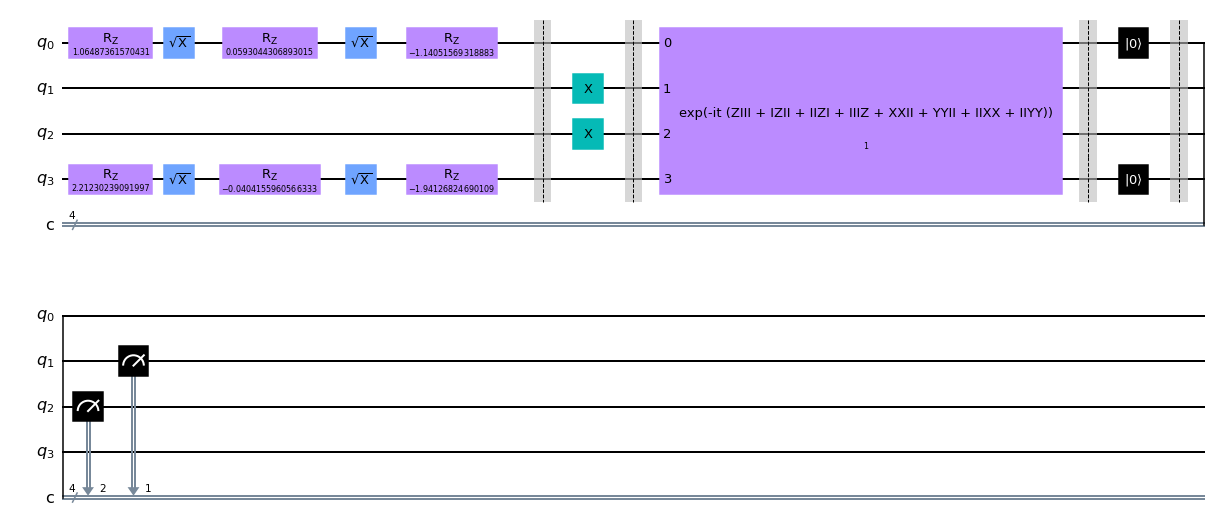

In [26]:
qc_heat_strokes[1].draw('mpl')

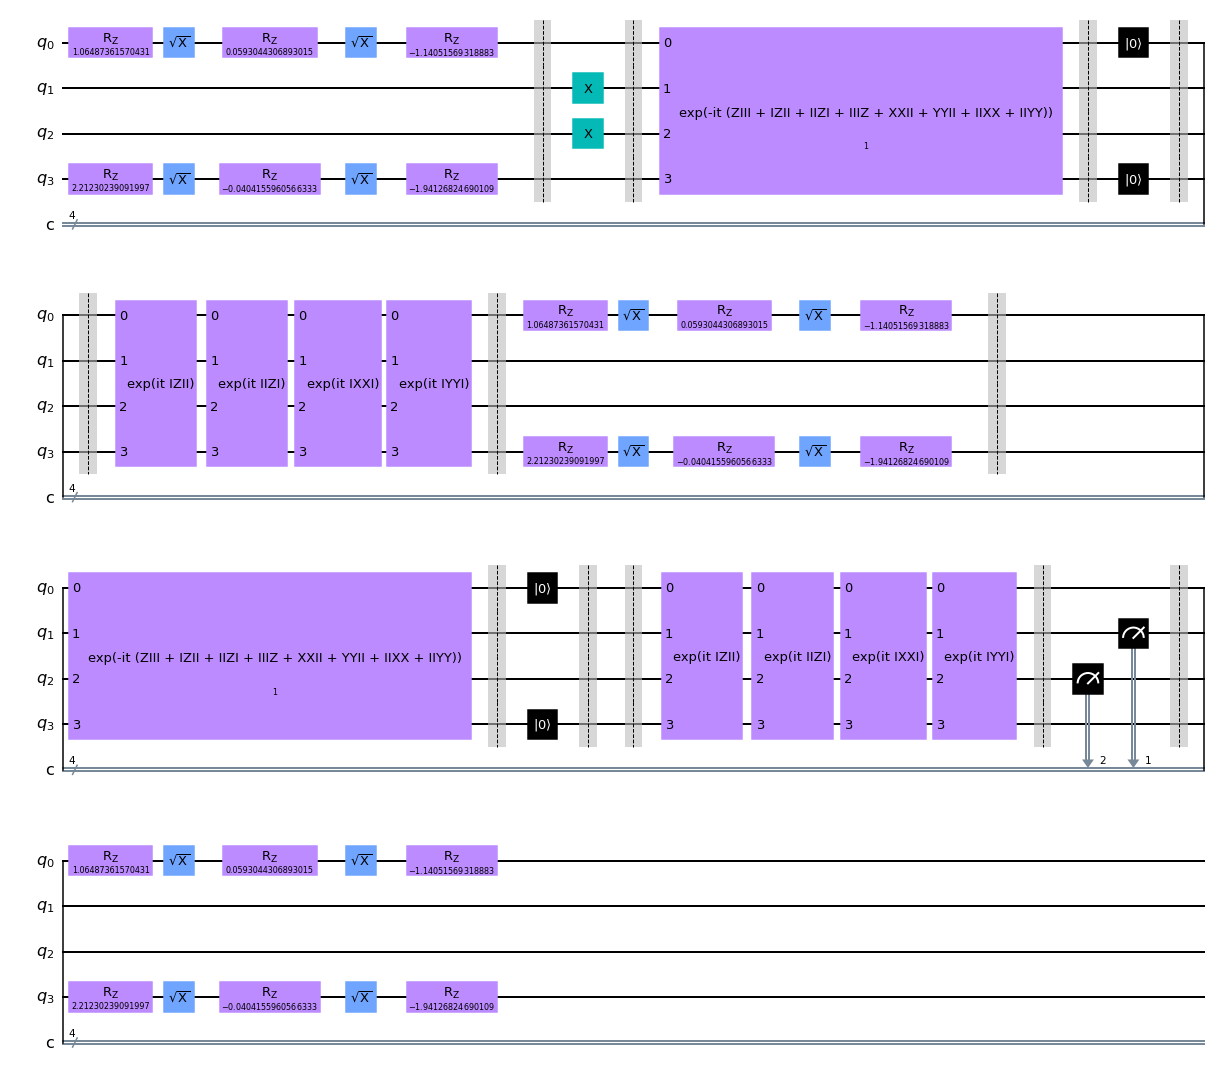

In [27]:
qc_work_strokes[1].draw('mpl')

In [28]:
#Transpiling the circuits:
qc_heat_transp= transpile(qc_heat_strokes, 
                          basis_gates=basis_gates,
                          optimization_level=3,
                          coupling_map=coupling_map,
                          initial_layout=initial_layout
                         )                

qc_work_transp = transpile(qc_work_strokes,
                           basis_gates=basis_gates, 
                           optimization_level=3,
                           coupling_map=coupling_map,
                           initial_layout=initial_layout
                          )

#Batch of transpiled circuits
transpiled_circuits = qc_heat_transp + qc_work_transp

Backend for the simulator:

In [29]:
#Number of shots
backend_sim = Aer.get_backend('qasm_simulator')
shots = 8192

In [30]:
n_exps = 10

qc_exp = transpiled_circuits*n_exps


job = execute(qc_exp,
              backend = backend_sim, #change to 'backend = backend' to run on real devices
              #noise_model = noise_model, #turn on noise_model on simulations
              #coupling_map = coupling_map, #turn on coupling_map on simulations
              #basis_gates = basis_gates, #turn on basis_gates on simulations
              shots = shots)
job_monitor(job, interval=2)
results = job.result()

exp_results = np.split(np.array(results.get_counts()),n_exps)

counts_heat_normal = []
counts_work_normal = []
for result in exp_results:
    counts_normal = np.split(np.array(result),[len(qc_heat_strokes)])
    counts_heat_normal.append(counts_normal[0].reshape(4,N+1))
    counts_work_normal.append(counts_normal[1].reshape(4,N))

Job Status: job has successfully run


In [31]:
counts_heat = counts_heat_normal
counts_work = counts_work_normal

In [32]:
def dict_reduction(counts_dict,qubit):
    """Computes all counts for a given basis element:

    Args:
        counts_dict (dict): Dictionary to be reducted
        qubit (int): Measured qubit

    Returns:
        dict: The reduced dictionary
    """
    
    dict_red = {}
    for i in ['0', '1']:
        value = 0
        for key in counts_dict:
            if key[qubit] == i:
                value += counts_dict[key]
                dict_red[i] = value
    return dict_red

Function to calculate $\langle Z \rangle$ for the subsystems.

In [33]:
combos = itertools.product([0, 1], repeat=2)
s = [list(c) for c in combos]

dist_final = prob_dist([dist_params_c,dist_params_h])

def z_expval(counts_stroke,meas_qubit):
    """Obtaining ZI and IZ for each sample

    Args:
        counts_stroke (List): Counts from job result for the corresponding stroke.
        meas_qubit (int): Measured qubit.

    Returns:
        List: Final <Z> values,
    """
    
    Z_samples = []
    for k in range(len(thermal_circs)):
        Z_aux = []
        for counts in counts_stroke[k]:
            counts = dict_reduction(counts,meas_qubit)
            # calculate the probabilities for each qubit value
            probs = {}
            for output in ['0', '1']:
                if output in counts:
                    probs[output] = counts[output]/shots
                else:
                    probs[output] = 0

            Z_aux.append(probs['0']-probs['1'])

        Z_samples.append(Z_aux)

    Z_samples = np.array(Z_samples).transpose()

    #Obtaining <Z> from the samples
    Z_vals = []
    for Z_samp in Z_samples:
        Z_final = 0
        for i, sample in zip(s,Z_samp):
            dist_aux = 1
            for j in range(0, len(i)):
                dist_aux = dist_final[j][i[j]]*dist_aux
            Z_final = Z_final + dist_aux*sample

        Z_vals.append(Z_final)
        
    return Z_vals

In [34]:
# Quantum chain
Z1_heat, Z2_heat, Z1_work, Z2_work = [], [], [], []
for c_heat, c_work in zip(counts_heat, counts_work):
    Z1_res, Z2_res = z_expval(c_heat,meas_qubit=1), z_expval(c_heat,meas_qubit=2)
    Z1_heat.append(Z1_res)
    Z2_heat.append(Z2_res)
    
    Z1_res, Z2_res = z_expval(c_work,meas_qubit=1), z_expval(c_work,meas_qubit=2)   
    Z1_work.append(Z1_res)
    Z2_work.append(Z2_res)

In [35]:
Qc_exps = []
Qh_exps = []
W_exps = []

for j in range(N):
    Qc_aux = []
    Qh_aux = []
    W_aux = []
    for i in range(n_exps):
        if j == 0:
            Qc_aux.append((wc/2)*(Z1_heat[i][j+1] - Z1_heat[i][j]))
            Qh_aux.append((wh/2)*(Z2_heat[i][j+1] - Z1_heat[i][j]))
        else:
            Qc_aux.append((wc/2)*(Z1_heat[i][j+1] - Z1_work[i][j-1]))
            Qh_aux.append((wh/2)*(Z2_heat[i][j+1] - Z2_work[i][j-1]))
    
        W_aux.append(-(wc/2)*(Z1_work[i][j]-Z1_heat[i][j+1])-(wh/2)*(Z2_work[i][j]-Z2_heat[i][j+1]))
        
    Qc_exps.append(Qc_aux)
    Qh_exps.append(Qh_aux)
    W_exps.append(W_aux)

In [36]:
Qc, Qc_err = [], []
Qh, Qh_err = [], []
W, W_err = [], []
for i in range(N):
    #Mean values
    Qc.append(np.mean(Qc_exps[i]))
    Qh.append(np.mean(Qh_exps[i]))
    W.append(np.mean(W_exps[i]))
    #Standard deviations of the mean
    Qc_err.append(3*np.std(Qc_exps[i])/np.sqrt(n_exps))
    Qh_err.append(3*np.std(Qh_exps[i])/np.sqrt(n_exps))
    W_err.append(3*np.std(W_exps[i])/np.sqrt(n_exps))

### Classical Simulation

This cell runs the classical simulation of the experiment.

In [37]:
%run ./1-strob_theory.ipynb

Classical simulation is finished.


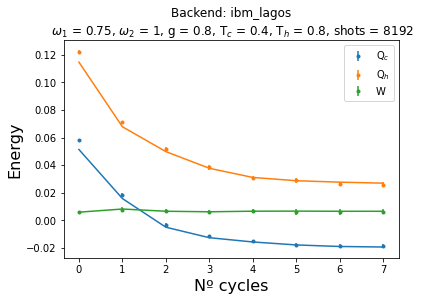

In [38]:
fig, axes = plt.subplots(1,1)

#QuTip
axes.plot(range(N), Qc_sim, color='tab:blue')
axes.plot(range(N), Qh_sim, color='tab:orange')
axes.plot(range(N), W_sim, color='tab:green')
#Qiskit
axes.errorbar(range(N), Qc, yerr=Qc_err, marker='.', linestyle='', color='tab:blue', label='Q$_c$')
axes.errorbar(range(N), Qh, yerr=Qh_err, marker='.', linestyle='', color='tab:orange', label='Q$_h$')
axes.errorbar(range(N), W, yerr=W_err, marker='.', linestyle='', color='tab:green', label='W')

axes.set_title('Backend: '+ back_str
               + '\n $\omega_1$ = ' + str(w1) + ', $\omega_2$ = ' + str(w2) + ', g = ' + str(gch)
               + ', T$_c$ = ' + str(Tc) + ', T$_h$ = ' + str(Th) + ', shots = ' + str(shots)
               )
axes.set_xlabel('Nº cycles', fontsize=16)
axes.set_ylabel('Energy', fontsize=16)
axes.legend(loc=1);

Saving the results:

In [39]:
saving = False

if saving == True:
    #Saving distributions
    save_results(dist_params_c,number+'_'+'prob_heat'+'_'+date+'_'+back_str)
    save_results(dist_params_h,number+'_'+'prob_work'+'_'+date+'_'+back_str)

    #Saving Normal Counts
    save_results(counts_heat_normal,number+'_'+'heat_non'+'_'+date+'_'+back_str)
    save_results(counts_work_normal,number+'_'+'work_non'+'_'+date+'_'+back_str)